# Conversion of SOLEIL SWING *.h5 files to video plot with:
- Diffusion image
- Basler image with spot position
- Integrations (Horizontal, Vertical, Iso)
- 2D map (Azimuth, Radial)

In [3]:
import glob
import os
from IPython.display import clear_output
import numpy as np
from matplotlib import pyplot as plt
import matplotlib.patches as patches
from IPython.display import HTML
import h5_integrate as integ
from IPython.display import clear_output
from moviepy.editor import ImageSequenceClip
%matplotlib widget

## Data extraction from h5 (images, positions and integrations) to numpy arrays

In [4]:
path = 'E:/Data_Soleil/lacroix/'
samplename='144d_10_500_g'
data_dir= path+samplename
offset = 0
sector_angle = 10
save_data = True
save_positions = True 
save_basler_image = True
mask='C:/Users/cayez/Documents/DONNEES SIMON/LPCNO/Synchrotron/SOLSEIL_SWINGjuillet24/notebooks/v2/images/mask.edf'  

In [5]:
dir=integ.extract_h5_from_dir(data_dir,offset,sector_angle,mask,save_data=save_data,
                              save_positions = save_positions, save_basler_image = save_basler_image)
print('Extracted Numpy arrays are stored in ',dir)

Extracted Numpy arrays are stored in  E:/Data_Soleil/lacroix/144d_10_500_g/144d_10_500_g


In [6]:
#dir='E:/Data_Soleil/lacroix/_200'

## Create Numpy files list of numpy in selected folder

In [7]:
#load and sort diffusion images of folder
image_file_list=glob.glob(dir+'/image/'+'*.npy')
image_file_list=sorted(image_file_list,key=integ.extract_number)

#load and sort positions images of folder
positions_file_list=glob.glob(dir+'/positions/'+'*.npy')
positions_file_list=sorted(positions_file_list,key=integ.extract_number)

#load and sort integration data of diffusion images
# intensities contains qh, qv and q_iso
intensities_file_list=glob.glob(dir+'/integration/'+'*_integrations.npy')
intensities_file_list=sorted(intensities_file_list,key=integ.extract_number)
q_file=glob.glob(dir+'/integration/'+'*_q.npy')[0]

#load and sort basler images of folder
basler_image_filelist=glob.glob(dir+'/basler_image/'+'*.npy')
basler_image_filelist=sorted(basler_image_filelist,key=integ.extract_number)
basler_image_file=basler_image_filelist[0]

#load and sort integration map images of folder
qmap_file=glob.glob(dir+'/integration/'+'*_qmap.npy')[0]
chimap_file = glob.glob(dir+'/integration/'+'*_chimap.npy')[0]
imap_file_list=glob.glob(dir+'/integration/'+'*_imap.npy')
imap_file_list=sorted(imap_file_list,key=integ.extract_number)

## Data visualization

Set Origin position on basler image

In [8]:
#expected values: X0=186, Z0=309
X0 = 186
Z0 = 309

# no crop:crop=1024
crop =712

and check...

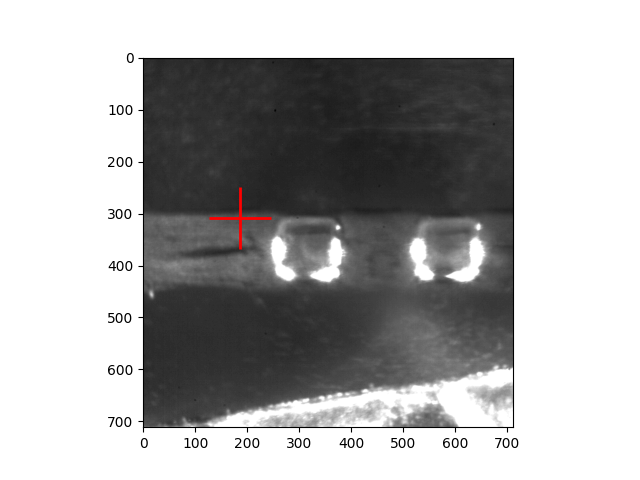

In [9]:
basler_image=np.load(basler_image_file)
fig,ax = plt.subplots()
ax.imshow(basler_image[0:crop,0:crop], cmap = 'gray')
ax.scatter(X0,Z0, s = 2000, marker = '+', color = 'r', linewidths=2)#, facecolor = None)

## Load numpy arrays from file list

In [10]:
# Load diffusion images
image = integ.read_numpy_from_list(image_file_list)

# load positions and determine position grid
positions=integ.read_numpy_from_list(positions_file_list)
x=positions[:,:,0]
z=positions[:,:,1]
nbre_lignes=positions.shape[0]
nbre_colonnes=positions.shape[1]
print('nbre of lines:',nbre_lignes,', nbre of columns:',nbre_colonnes)

#load integration data
integrations= integ.read_numpy_from_list(intensities_file_list)
q_array=np.load(q_file)
qh=q_array[0]
qv=q_array[1]
q_iso=q_array[2]

# load integration maps
qmap=np.load(qmap_file)
chimap=np.load(chimap_file)
imaps=integ.read_numpy_from_list(imap_file_list)



nbre of lines: 21 , nbre of columns: 10


## Create and check position grid

step_x 24.988888888891836 step_z 25.600000000000733


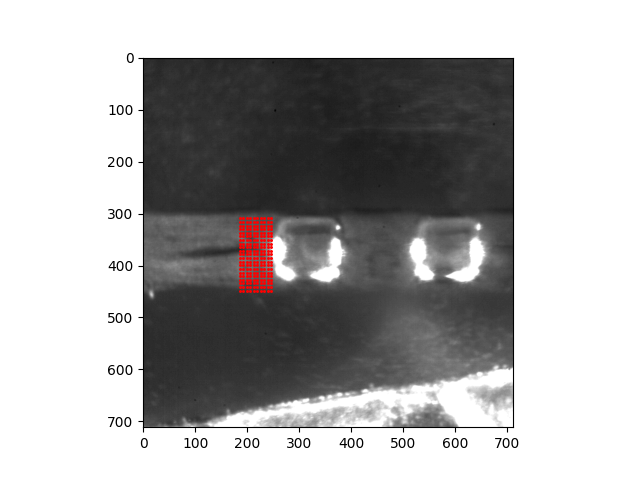

In [11]:
# basler_image=np.load(basler_image_file)
fig,ax=plt.subplots()
ax.imshow(basler_image[0:crop,0:crop],cmap='gray')


#calculate deta x and delta z and Convert in µm
if nbre_colonnes==1:
    step_x=0
else:
    step_x = 1000*(x[0,1]-x[0,0])
#step_x=0.025   
if nbre_lignes==1:
    step_z=0
else:
    step_z= 1000*(z[1,0]-z[0,0])
print('step_x', step_x,'step_z',step_z)
rect_coordinates = np.array([X0,Z0])

positions_pixels = np.empty_like(positions)
for k in range (nbre_colonnes):
    for l in range (nbre_lignes):
        x_pix = rect_coordinates[0]+k*(step_x/3.73)
        z_pix = rect_coordinates[1]+l*(step_z/3.67)
        positions_pixels[l,k] = np.array([x_pix,z_pix])
x_pixels_ok=positions_pixels[:,:,0]
z_pixels_ok=positions_pixels[:,:,1] 

ax.scatter(positions_pixels[:,:,0],positions_pixels[:,:,1],marker='.',s=5,color = 'r')


## Plot all data in subplots and save plots

In [12]:
samplename=data_dir.split('/')[-1]

plotdir=dir+'/plots'
os.makedirs(plotdir,exist_ok=True)
plt.ioff()
k=1
nbre_fichiers=nbre_colonnes*nbre_lignes
for i in range (nbre_lignes):
    for j in range(nbre_colonnes):
        fig,ax=plt.subplots(2,2,figsize=(10,10))
        
        ax[0,0].imshow(basler_image[0:crop,0:crop],cmap='gray')
        ax[0,0].scatter(x_pixels_ok,z_pixels_ok,s=2,marker='.',color='y')
        ax[0,0].scatter(x_pixels_ok[i][j],z_pixels_ok[i][j],s=15,marker='o',color='r')

        ax[0,1].imshow(image[i][j][518:,545:],cmap='jet')

        ax[1,0].loglog(qh,integrations[i,j,0,:],label='h')
        #ax.loglog(qh,integrations[0][0][0])
        ax[1,0].loglog(qv,integrations[i,j,1,:],label='v')
        ax[1,0].loglog(q_iso,integrations[i,j,2,:],label='iso')
        ax[1,0].legend()
        fig.suptitle(samplename+', x=%.2f'%x[i,j]+', z=%.2f'%z[i,j])
        figname=plotdir+'/plot_line%02d'%i+'_column%02d'%j+'.png'

        ax[1,1].set_xscale('log')
        ax[1,1].set_xlabel('q 1/A')
        ax[1,1].set_ylabel('Azimuhtal angle (°)')
        cax=ax[1,1].imshow(np.log1p(imaps[i][j]),origin="lower",extent=[qmap.min(),qmap.max(),chimap.min(),chimap.max()],aspect="auto",cmap='jet')
        #fig.colorbar(cax, ax = ax[1,1])
            
        plt.tight_layout()
        plt.savefig(figname)
        print('File %d'%k, ' out of %d '%nbre_fichiers)
        clear_output(wait=True)
        k+=1
      
        


File 210  out of 210 


## Convert to video

In [ ]:
#plotdir=dir+'/plots'
#image_folder = plotdir

In [13]:
print(dir)
samplename=data_dir.split('/')[-1]
#Specify the path to your images
image_folder = dir+'/plots'
plotfile_list=[]
for i in range(nbre_lignes):
    for j in range (nbre_colonnes):
        plotfile_list.append('plot_line%02d'%i+'_column%02d'%j+'.png')

image_files = [f'{image_folder}/{file}' for file in plotfile_list] 

# Create a video clip from the images
clip = ImageSequenceClip(image_files, fps=2)  # Set the desired frames per second (fps)

# Write the video file
clip.write_videofile(dir+'/'+f'{samplename}_video.mp4', codec='libx264')  # Output video file

E:/Data_Soleil/lacroix/144d_10_500_g/144d_10_500_g
Moviepy - Building video E:/Data_Soleil/lacroix/144d_10_500_g/144d_10_500_g/144d_10_500_g_video.mp4.
Moviepy - Writing video E:/Data_Soleil/lacroix/144d_10_500_g/144d_10_500_g/144d_10_500_g_video.mp4



Moviepy - Done !
Moviepy - video ready E:/Data_Soleil/lacroix/144d_10_500_g/144d_10_500_g/144d_10_500_g_video.mp4
